In [1]:
import numpy

from objects import NormalModel, TransitionDensity
from utils import rand_obs, rand_nnd, model_extract
import matplotlib.pyplot as plt
from numpy import ndarray as Array
from funcs import forward, backward, beyond
from memory import DLModelMemory, DLModelPrimeMemory
from components import gen_fullform, gen_harmonics, gen_jordan
from generate import DLModelTestGen, DLModelGenerator
from dataload import weather_dataframe
from config import CSV_PATH
import numpy

In [2]:
def random_nan(array: "numpy.ndarray", nans: "int") -> "numpy.ndarray":

    numpy.put(array, numpy.random.choice(array.size, nans, replace=False), numpy.nan)

    return array

In [3]:
dataset = weather_dataframe(CSV_PATH)

data_array = dataset[["humidity(%)"]].to_numpy(dtype=float)

data_array = random_nan(data_array, 0)

observations = [data_array[i:(i+1)].T for i in range(data_array.shape[0])]

In [4]:
observation = observations[2]

numpy.argwhere(numpy.isnan(observation))

observation

array([[73.]])

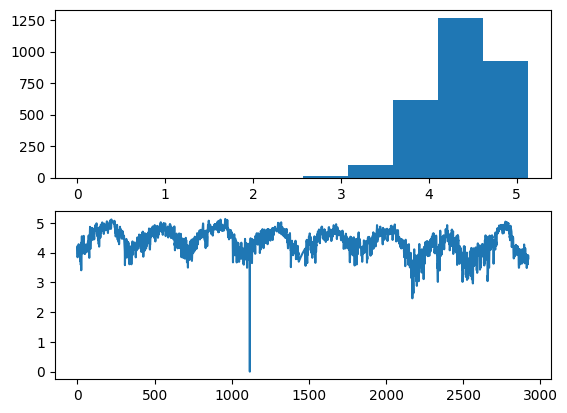

In [5]:
import math

fig, axs = plt.subplots(2)

data = dataset["O3#AGP(μg/m3)"]

x_data = list(range(len(data)))
y_data = [math.log(float(i)) for i in data.to_list()]

axs[0].hist(y_data)
axs[1].plot(x_data, y_data)

plt.show()



In [6]:
# Model's observable period
period: "int" = len(observations)

# Model's predicted period
beyond_period: "int" = 50

# Components engineering
full_comp = gen_jordan(1, 1) + gen_harmonics(1,10,1)

# Dimensional parameters
n: "int" = 1
m: "int" = 1
p: "int" = full_comp.obs_matrix.shape[1]

# Primordial model setting
n0: "NormalModel" = rand_obs((p,n))
n0.covariance = rand_nnd(p, 1)

# Evolver setting
b_e: "Array" = numpy.zeros((p, n)) # p by n
a_e: "Array" = full_comp.trans_matrix # p by p
v_e: "Array" = numpy.eye(p) * 1
te: "TransitionDensity" = TransitionDensity(b_e, a_e, v_e)

# Predictor setting
b_p: "Array" = numpy.zeros((m, n)) # m by n
a_p: "Array" = full_comp.obs_matrix # m by p
v_p: "Array" = numpy.eye(m) * 50
tp: "TransitionDensity" = TransitionDensity(b_p, a_p, v_p)

In [7]:
import funcs

prime_memory = funcs.PrimeMemoryDLM(
    forward_period=period,
    beyond_period=beyond_period,
    primordial_model=n0,
    evolver=te,
    observer=tp,
    observations=observations
)

In [8]:
prime: "DLModelPrimeMemory" = DLModelPrimeMemory(n=n, m=m, p=p, period=period, beyond_period=beyond_period, n0=n0, te=te, tp=tp)
memory: "DLModelMemory" = DLModelMemory()
gen: "DLModelGenerator" = DLModelTestGen()

In [9]:
memory = forward(
    prime=prime,
    memory=memory,
    gen=gen
)

In [10]:
memory = backward(
    prime=prime,
    memory=memory
)
memory = beyond(
    prime=prime,
    memory=memory,
    gen=gen
)

In [11]:
new_memory = funcs.new_forward(prime_memory=prime_memory)
new_memory = funcs.new_backward(prime_memory=prime_memory, memory=new_memory)
new_memory = funcs.new_beyond(prime_memory=prime_memory, memory=new_memory)

IndexError: list index out of range

In [18]:
new_memory.filtered_states[prime_memory.forward_period]

NormalModel(mean=array([[ 3.84706728e+01],
       [ 3.43587250e+01],
       [ 1.08878954e+01],
       [-4.15206334e-01],
       [ 7.82360399e+00],
       [ 7.70783570e-01],
       [ 1.39154851e+00],
       [ 2.55782630e+00],
       [-2.95006589e+00],
       [ 3.02087030e+00],
       [ 4.25702756e+00],
       [ 1.52836682e-02],
       [-1.21215893e+00],
       [-4.09086976e+00],
       [-1.16143612e+00],
       [-4.63790718e+00],
       [-1.40280199e+00],
       [-2.86043141e+00],
       [-1.86805429e-01]]), covariance=array([[ 1.46486388e+03, -1.45880952e+03, -3.36057298e-01,
        -3.53553391e-01,  3.50171827e-01, -5.70248361e-01,
         9.02781248e-02, -6.85600650e-01,  1.73065734e-01,
        -7.88507539e-01,  3.19159299e-01, -8.30244213e-01,
         5.57399809e-01, -7.31061061e-01,  8.90805816e-01,
        -3.42772341e-01,  1.26079891e+00,  6.72234285e-01,
         1.29817530e+00],
       [-1.45880952e+03,  1.46486388e+03,  3.36057298e-01,
        -3.53553391e-01, -3.50171827e

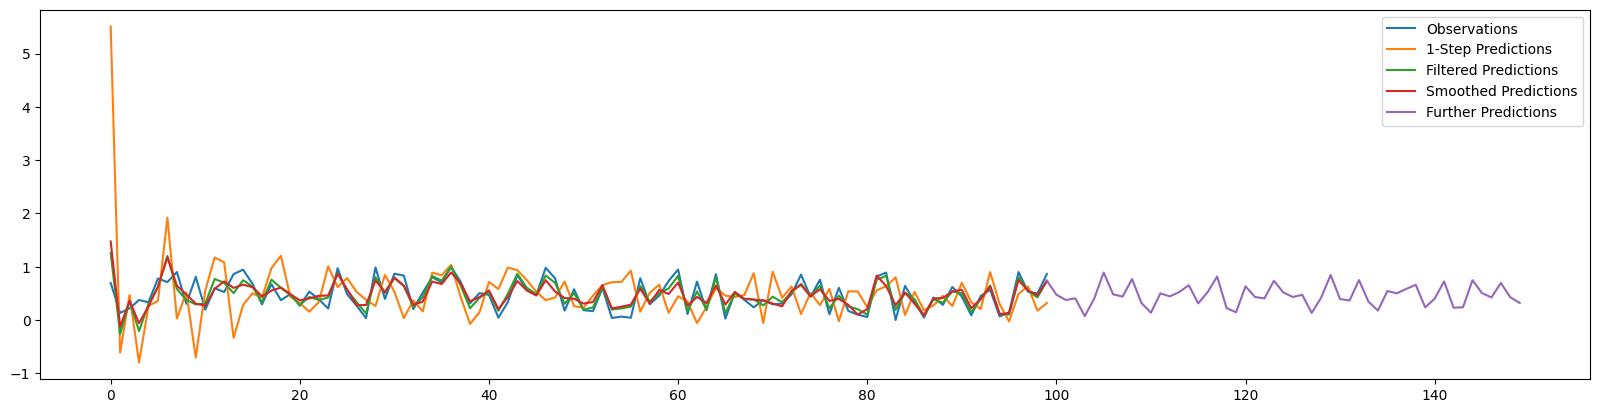

In [ ]:
fig, ax = plt.subplots()

x1_data = list(range(period))
x2_data = list(range(period-1, period + beyond_period))

# y1_data = list(model_extract(new_memory))
y2_data = list(model_extract(new_memory.evolved_spaces))
y3_data = list(model_extract(new_memory.filtered_spaces))
y4_data = list(model_extract(new_memory.smoothed_spaces))
y5_data = list(model_extract(new_memory.predicted_spaces))

# ax.plot(x1_data, y1_data, label="Observations")
ax.plot(x1_data, y2_data, label="1-Step Predictions")
ax.plot(x1_data, y3_data, label="Filtered Predictions")
ax.plot(x1_data, y4_data, label="Smoothed Predictions")
ax.plot(x2_data, y5_data, label="Further Predictions")

ax.legend()
fig.set_figwidth(20)
plt.show()